# Tensorflow MNIST model and Triton (e2e example)

## Prerequisites

 * A kubernetes cluster with kubectl configured
 * rclone
 * curl
 * Poetry (optional)

## Setup Seldon Core

Use the setup notebook to [Setup Cluster](https://docs.seldon.io/projects/seldon-core/en/latest/examples/seldon_core_setup.html#Setup-Cluster) with [Ambassador Ingress](https://docs.seldon.io/projects/seldon-core/en/latest/examples/seldon_core_setup.html#Ambassador) and [Install Seldon Core](https://docs.seldon.io/projects/seldon-core/en/latest/examples/seldon_core_setup.html#Install-Seldon-Core). Instructions [also online](https://docs.seldon.io/projects/seldon-core/en/latest/examples/seldon_core_setup.html).

We will assume that ambassador (or Istio) ingress is port-forwarded to `localhost:8003`

## Setup MinIO

Use the provided [notebook](https://docs.seldon.io/projects/seldon-core/en/latest/examples/minio_setup.html) to install Minio in your cluster.
Instructions [also online](https://docs.seldon.io/projects/seldon-core/en/latest/examples/minio_setup.html).

We will assume that MinIO service is port-forwarded to `localhost:8090`

In [1]:
%%writefile rclone.conf
[s3]
type = s3
provider = minio
env_auth = false
access_key_id = admin@seldon.io
secret_access_key = 12341234
endpoint = http://localhost:8090

Overwriting rclone.conf


In [2]:
%%writefile secret.yaml
apiVersion: v1
kind: Secret
metadata:
  name: seldon-rclone-secret
type: Opaque
stringData:
  RCLONE_CONFIG_S3_TYPE: s3
  RCLONE_CONFIG_S3_PROVIDER: minio
  RCLONE_CONFIG_S3_ENV_AUTH: "false"
  RCLONE_CONFIG_S3_ACCESS_KEY_ID: "admin@seldon.io"
  RCLONE_CONFIG_S3_SECRET_ACCESS_KEY: "12341234"
  RCLONE_CONFIG_S3_ENDPOINT: http://minio.minio-system.svc.cluster.local:9000

Overwriting secret.yaml


In [3]:
!kubectl apply -f secret.yaml

secret/seldon-rclone-secret configured


## Poetry (optional)

We will use poetry.lock to fully define the training environment. 
Install poetry following official documentation. Usually this goes down to
```
curl -sSL https://raw.githubusercontent.com/python-poetry/poetry/master/get-poetry.py | python3 -
```

Note: as runtime environment will be defined by the Triton Server image this step is optional. However, keeping the training environment fully reproducible is usually a right thing to do.

## Train MNIST Model

### Prepare training environment

In [4]:
!conda create --yes --prefix ./venv python=3.8

Solving environment: done

## Package Plan ##

  environment location: /home/rskolasinski/work/seldon-core-mnist-triton/examples/mnist_triton_e2e/venv

  added / updated specs:
    - conda-ecosystem-user-package-isolation
    - python=3.8


The following NEW packages will be INSTALLED:

  _libgcc_mutex      conda-forge/linux-64::_libgcc_mutex-0.1-conda_forge
  _openmp_mutex      conda-forge/linux-64::_openmp_mutex-4.5-1_gnu
  ca-certificates    conda-forge/linux-64::ca-certificates-2021.10.8-ha878542_0
  conda-ecosystem-u~ conda-forge/linux-64::conda-ecosystem-user-package-isolation-1.0-0
  ld_impl_linux-64   conda-forge/linux-64::ld_impl_linux-64-2.36.1-hea4e1c9_2
  libffi             conda-forge/linux-64::libffi-3.4.2-h9c3ff4c_4
  libgcc-ng          conda-forge/linux-64::libgcc-ng-11.2.0-h1d223b6_11
  libgomp            conda-forge/linux-64::libgomp-11.2.0-h1d223b6_11
  libnsl             conda-forge/linux-64::libnsl-2.0.0-h7f98852_0
  libstdcxx-ng       conda-forge/linux-64::libstdc

In [5]:
%%writefile pyproject.toml
[tool.poetry]
name = "mnist_triton_e2e"
version = "0.1.0"
description = ""
authors = ["Seldon Technologies Ltd. <hello@seldon.io>"]
license = "Apache-2.0"

[tool.poetry.dependencies]
python = "~3.8"
tensorflow = "2.6.2"

[tool.poetry.dev-dependencies]

[build-system]
requires = ["poetry-core>=1.0.0"]
build-backend = "poetry.core.masonry.api"

Overwriting pyproject.toml


On first run of `poetry install` command it will create a `poetry.lock` file. Every next run of the installation command will use the package version from the lock file.

In [6]:
%%bash
source ~/miniconda3/etc/profile.d/conda.sh
conda activate ./venv
poetry install

Installing dependencies from lock file

Package operations: 37 installs, 0 updates, 0 removals

  • Installing certifi (2021.10.8)
  • Installing charset-normalizer (2.0.7)
  • Installing idna (3.3)
  • Installing pyasn1 (0.4.8)
  • Installing urllib3 (1.26.7)
  • Installing cachetools (4.2.4)
  • Installing oauthlib (3.1.1)
  • Installing pyasn1-modules (0.2.8)
  • Installing rsa (4.7.2)
  • Installing requests (2.26.0)
  • Installing six (1.15.0)
  • Installing google-auth (1.35.0)
  • Installing requests-oauthlib (1.3.0)
  • Installing absl-py (0.15.0)
  • Installing google-auth-oauthlib (0.4.6)
  • Installing grpcio (1.41.1)
  • Installing numpy (1.19.5)
  • Installing tensorboard-data-server (0.6.1)
  • Installing tensorboard-plugin-wit (1.8.0)
  • Installing protobuf (3.19.1)
  • Installing werkzeug (2.0.2)
  • Installing markdown (3.3.4)
  • Installing astunparse (1.6.3)
  • Installing clang (5.0)
  • Installing gast (0.4.0)
  • Installing google-pasta (0.2.0)
  • Installing ker

### Prepare Training Script

In [7]:
%%writefile train.py

import numpy as np
np.random.seed(123)   # for reproducibility

from tensorflow.keras.layers import (Activation, Convolution2D, Dense, Dropout,
                                     Flatten, MaxPooling2D)
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical

from tensorflow.keras.datasets import mnist


# Load pre-shuffled MNIST data into train and test sets
(X_train, y_train), (X_test, y_test) = mnist.load_data()

# Reshape data for Tensorflow
X_train = X_train.reshape(-1, 28, 28, 1)
X_test = X_test.reshape(-1, 28, 28, 1)

X_train = X_train.astype("float32")
X_test = X_test.astype("float32")
X_train /= 255
X_test /= 255

# Convert 1-dimensional class arrays to 10-dimensional class matrices
Y_train = to_categorical(y_train, 10)
Y_test = to_categorical(y_test, 10)

# define model
model = Sequential()

# declare input layer
model.add(Convolution2D(32, (3, 3), activation="relu", input_shape=(28, 28, 1)))

# add more layers
model.add(Convolution2D(32, (3, 3), activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# and even more layers
model.add(Flatten())
model.add(Dense(128, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(10, activation="softmax"))

model.summary()

# compile model and train
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
model.fit(X_train, Y_train, epochs=4, batch_size=32, verbose=1)

score = model.evaluate(X_test, Y_test, verbose=0)
print("\n%s: %.2f%%" % (model.metrics_names[1], score[1] * 100))

# save model
model.save("models-repository/mnist/1/model.savedmodel")

Overwriting train.py


### Train Model

In [8]:
!./venv/bin/python3 train.py

2021-11-09 00:16:11.767552: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-09 00:16:11.774042: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-09 00:16:11.774341: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-09 00:16:11.774801: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

## Deploy and Test

### Configure Triton Server

In [9]:
%%writefile models-repository/mnist/config.pbtxt
name: "mnist"
platform: "tensorflow_savedmodel"
max_batch_size: 100
dynamic_batching { preferred_batch_size: [ 50 ]}
instance_group [ { count: 2 }]
input [
  {
    name: "conv2d_input"
    data_type: TYPE_FP32
    dims: [ 28, 28, 1 ]
  }
]
output [
  {
    name: "dense_1"
    data_type: TYPE_FP32
    dims: [ 10 ]
  }
]

Overwriting models-repository/mnist/config.pbtxt


### Copy model into MinIO instance

In [10]:
!tree models-repository/

models-repository/
└── mnist
    ├── 1
    │   └── model.savedmodel
    │       ├── assets
    │       ├── keras_metadata.pb
    │       ├── saved_model.pb
    │       └── variables
    │           ├── variables.data-00000-of-00001
    │           └── variables.index
    └── config.pbtxt

5 directories, 5 files


In [11]:
!rclone -vvv --config="rclone.conf" copy models-repository s3://triton-models/mnist-model

2021/11/09 00:16:39 DEBUG : rclone: Version "v1.56.2" starting with parameters ["/home/rskolasinski/.asdf/installs/rclone/1.56.2/bin/rclone" "-vvv" "--config=rclone.conf" "copy" "models-repository" "s3://triton-models/mnist-model"]
2021/11/09 00:16:39 DEBUG : Creating backend with remote "models-repository"
2021/11/09 00:16:39 DEBUG : Using config file from "/home/rskolasinski/work/seldon-core-mnist-triton/examples/mnist_triton_e2e/rclone.conf"
2021/11/09 00:16:39 DEBUG : fs cache: renaming cache item "models-repository" to be canonical "/home/rskolasinski/work/seldon-core-mnist-triton/examples/mnist_triton_e2e/models-repository"
2021/11/09 00:16:39 DEBUG : Creating backend with remote "s3://triton-models/mnist-model"
2021/11/09 00:16:39 DEBUG : fs cache: renaming cache item "s3://triton-models/mnist-model" to be canonical "s3:triton-models/mnist-model"
2021/11/09 00:16:39 DEBUG : mnist/config.pbtxt: Modification times differ by -8m54.901977129s: 2021-11-09 00:16:39.278686721 +0000 GMT

### Deploy

In [12]:
%%writefile deployment.yaml
apiVersion: machinelearning.seldon.io/v1
kind: SeldonDeployment
metadata:
  name: mnist
  namespace: seldon
spec:
  name: default
  predictors:
  - graph:
      implementation: TRITON_SERVER
      logger:
        mode: all
      modelUri: s3:triton-models/mnist-model
      envSecretRefName: seldon-rclone-secret
      name: mnist
      type: MODEL
    name: default
    replicas: 1
  protocol: kfserving

Overwriting deployment.yaml


In [13]:
!kubectl apply -f deployment.yaml

seldondeployment.machinelearning.seldon.io/mnist unchanged


In [14]:
!kubectl rollout status deploy/$(kubectl get deploy -l seldon-deployment-id=mnist -o jsonpath='{.items[0].metadata.name}')

deployment "mnist-default-0-mnist" successfully rolled out


### Test (dummy data)

In [15]:
import numpy as np
import requests

In [16]:
!curl -s http://localhost:8003/seldon/seldon/mnist/v2/models/mnist | jq .

{
  "name": "mnist",
  "versions": [
    "1"
  ],
  "platform": "tensorflow_savedmodel",
  "inputs": [
    {
      "name": "conv2d_input",
      "datatype": "FP32",
      "shape": [
        -1,
        28,
        28,
        1
      ]
    }
  ],
  "outputs": [
    {
      "name": "dense_1",
      "datatype": "FP32",
      "shape": [
        -1,
        10
      ]
    }
  ]
}


In [17]:
URL = "http://localhost:8003/seldon/seldon/mnist"

def predict(data):
    data = {
        "inputs": [
            {
                "name": "conv2d_input",
                "data": data.tolist(),
                "datatype": "FP32",
                "shape": data.shape,
            }
        ]
    }

    r = requests.post(f"{URL}/v2/models/mnist/infer", json=data)
    predictions = np.array(r.json()["outputs"][0]["data"]).reshape(
        r.json()["outputs"][0]["shape"]
    )
    output = [np.argmax(x) for x in predictions]
    return output

In [18]:
output = predict(np.random.rand(10, 28, 28, 1))
output

[8, 8, 8, 8, 2, 8, 8, 8, 8, 3]

### Test (real data - optional)

In [19]:
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt

2021-11-09 00:16:41.193198: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


In [20]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

X_test = X_test.reshape(-1, 28, 28, 1)
X_test = X_test.astype("float32")
X_test /= 255

Y_test = to_categorical(y_test, 10)

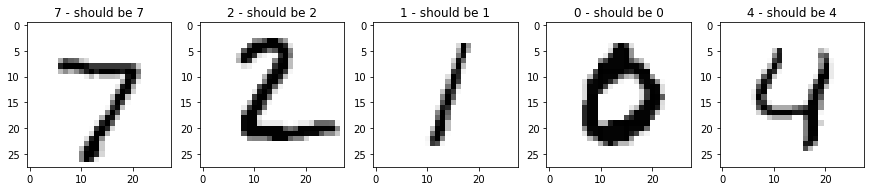

In [21]:
predictions = predict(X_test[:5])
fig, axs = plt.subplots(1, 5, figsize=(15, 3))

for i in range(5):
    axs[i].imshow(X_test[i, :, :, 0], cmap="binary")
    axs[i].set_title("{} - should be {}".format(predictions[i], np.argmax(Y_test[i])))